<img src="https://raw.githubusercontent.com/nlpfromscratch/nlpfor.me/refs/heads/master/assets/cover_image_PT3.png"/>

# Machine Learning and Sentiment Analysis

Copyright, NLP from scratch, 2024.

[NLPfor.me](https://www.nlpfor.me)

------------

## Sentiment Analysis using Rules-Based Models

### Using `nltk`
A sentiment model scoring model is built into `nltk`. It is based upon the [VADER (*V*alence *A*ware *D*ictionary and s*E*ntiment *R*easoner) model](https://github.com/cjhutto/vaderSentiment) which is a rules and lexicon based sentiment scoring model, by C.J. Hutto and E.E. Gilbert.

First we must download the `vader` package within NLTK:

In [1]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\myles\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Now that the package has been downloaded, we create an object of type `SentimentIntensityAnalyzer`:

In [2]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

Now we can pass string data into the analyzer and receive sentiment scores in return by calling the `polarity_scores` method:

In [3]:
samplestring = "I love applesauce, it's the greatest!"
display(samplestring)

"I love applesauce, it's the greatest!"

In [4]:
scores = sia.polarity_scores(samplestring)
display(scores)

{'neg': 0.0, 'neu': 0.257, 'pos': 0.743, 'compound': 0.8655}

We can see the analyzer returns multiple scores:
- A `neg`ative score, the likelihood the sentiment is negative
- A `neu`tral score, the likelihood the sentiment is neutral
- A `pos`itive score, the likelihood the sentiment is positive

All of these above are expressed as probabilities from 0-1, and so should add to 1:

In [5]:
print(scores['neg'] + scores['neu'] + scores['pos'])

1.0


Furthermore, a `compound` score is returned, which is the standard sentiment score, a real value between -1 and 1 for negative and positive sentiment respectively:

In [6]:
# Positive
sia.polarity_scores('I love applesauce, it is the greatest')['compound']

0.8555

In [7]:
# Negative
sia.polarity_scores('I hate applesauce, it is just the worst')['compound']

-0.8316

In [8]:
# Neutral
sia.polarity_scores('Applesauce is ok, I guess. I am indifferent toward it.')['compound']

0.1027

### Using `TextBlob`

[TextBlob](https://textblob.readthedocs.io/) is a general-purpose text processing and NLP library for a number of tasks, including sentiment. The sentiment scoring model in TextBlob is based upon that in the [pattern library](https://github.com/clips/pattern) for information mining.

To do sentiment analysis with TextBlob, we create a `TextBlob` object:

In [9]:
from textblob import TextBlob

sampleblob = TextBlob(samplestring)
sampleblob

TextBlob("I love applesauce, it's the greatest!")

By default, the object has a precomputed `sentiment` attribute:

In [10]:
sampleblob.sentiment

Sentiment(polarity=0.75, subjectivity=0.8)

We can see TextBlob returns both a sentiment polarity which ranges from -1 to 1, as well as a subjectivity score (0-1):


In [11]:
TextBlob('Applesauce is ok, I guess. I am indifferent toward it.').sentiment

Sentiment(polarity=0.5, subjectivity=0.5)

## Training a Sentiment Model from Scratch

Now we will be apply supervised learning to a sentiment analysis problem by training a model on labelled data. First we will load and preprocess a labelled text dataset, then fit and use a simple linear model for the binary classification task of positive and negative sentiment.

Here we be working a random 10% sample of the [Large Movie Review Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), a set of 50,000 "highly polar" movie reviews collected from the [Internet Movie Database](https://www.imdb.com).

First, we'll read in the data:

In [12]:
import pandas as pd

reviews_df = pd.read_csv('https://raw.githubusercontent.com/nlpfromscratch/datasets/refs/heads/master/imdb/imdb_reviews_sample.csv')

Let's take a look at the data and see what we are working with:

In [13]:
reviews_df.head()

,review,sentiment
0,Valley Girl is an exceptionally well made film...,1
1,This is one of those inoffensive and mildly en...,0
2,I really wanted to like this movie - the locat...,0
3,I attended the premier last night. The movie s...,0
4,The Deadly Wake is THE PERFECT MOVIE for film ...,0


We can see that the there are two columns, the free-form text in the column `review`, and the sentiment class label in the column `sentiment`, with a zero for negative reviews and one for positive reviews. We can also see that we'll need to do some text preprocessing, as there are different letter cases and punctuation present in the review text.

In [14]:
reviews_df['review'][0]

'Valley Girl is an exceptionally well made film with an all-around great cast. Even though the dialogue is a bit dated now, when the movie was released it was very hip. To this day, I know many people (teenagers included) that cannot form a sentence without using the word "like". That is without a doubt the legacy this movie will leave. A rating of 8 was given for this, like, most excellent movie.'

Because we have already covered preprocessing in [Part 2](https://github.com/mylesmharrison/nlp4free/blob/master/notebooks/NLP4Free_Part2_DataAcquisitionandPreprocessing.ipynb), we will gloss over the details here and apply the necessary steps all at once. Only here now, we are applying the preprocessing steps to all documents (reviews) in our corpus, instead of a single piece of text. We opt not to apply stemming in this case for simplicity's sake, and see if we are still able to attain good results.

In [15]:
# Make a copy of the original dataframe
processed_df = reviews_df.copy()

# Change everything to lowercase
processed_df['review'] = processed_df['review'].str.lower()

# Remove punctuation with regular expression (https://en.wikipedia.org/wiki/Regular_expression)
processed_df['review'] = processed_df['review'].str.replace(r'[^\w\s]+', '')

# Check
processed_df.head()

,review,sentiment
0,valley girl is an exceptionally well made film...,1
1,this is one of those inoffensive and mildly en...,0
2,i really wanted to like this movie - the locat...,0
3,i attended the premier last night. the movie s...,0
4,the deadly wake is the perfect movie for film ...,0


In [16]:
processed_df['review'][0]

'valley girl is an exceptionally well made film with an all-around great cast. even though the dialogue is a bit dated now, when the movie was released it was very hip. to this day, i know many people (teenagers included) that cannot form a sentence without using the word "like". that is without a doubt the legacy this movie will leave. a rating of 8 was given for this, like, most excellent movie.'

In [17]:
# Apply count vectorization and remove stopwords
# Use the min_df parameter to only keep tokens which appear in at least 1% of documents (50 reviews or more)
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english', min_df=0.01)
X = cv.fit_transform(reviews_df['review'])
X

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 269110 stored elements and shape (5000, 1565)>

We can see that we have a 5,000 row dataframe with 1,565 columns - which are the features made up of the token counts. This matrix is sparse, so let's convert it to a nice dataframe for convenience. We will also use the tokens stored in the count vectorizer as the feature names to be the column names:

In [18]:
X = pd.DataFrame(X.toarray(), columns=cv.get_feature_names_out())

# Check
X.head()

,10,100,11,12,13,15,20,30,40,50,...,wrong,wrote,yeah,year,years,yes,york,young,younger,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can see that the dataframe is mostly zeros, as most tokens only appear in a very small number of reviews. Here we will also pull out the `y` variable which will be our target for the binary classification task:

In [19]:
y = processed_df['sentiment']
y.head()

0    1
1    0
2    0
3    0
4    0
Name: sentiment, dtype: int64

We now have our preprocessed text data and an associated target, and so we are ready to fit a supervised machine learning model.

### Fitting a Simple Linear Model

Now that we have our training data and target feature, we can fit a simple linear model to make predictions about the sentiment of a given movie review from the words contained within. In this case, since we are doing a binary classification task, we will be using a [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) model, a type of linear classifier which returns probabilities between 0 and 1.

First, in order to prevent overfitting, we will need to split our data into a training set and a test set. We can do this easily using the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function which is specifically designed for this purpose. Here we take a test set of 30%, and use 70% for training:

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Now we can fit our model. In scikit-learn, this is as easy as a few lines of code. We first import the `LogisticRegression` model class, then fit it on the training data, then call `.score`, passing in the training and test sets to get back accuracy scores.

In [21]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()

logit.fit(X_train, y_train)

display(logit.score(X_train, y_train))
display(logit.score(X_test, y_test))

C:\Users\myles\venv\nlpforme\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.988

0.8266666666666667

Here we can see our model is quite overfit, as the score on the training set is much higher than test set. Nonetheless, we will proceed. Since positive sentiment is class 1, the model coefficients which are positive will be more predictive of positive sentiment, and those which are negative more predictive of negative sentiment.

We can take a look at the most predictive features (tokens) below with a few simple lines of code:

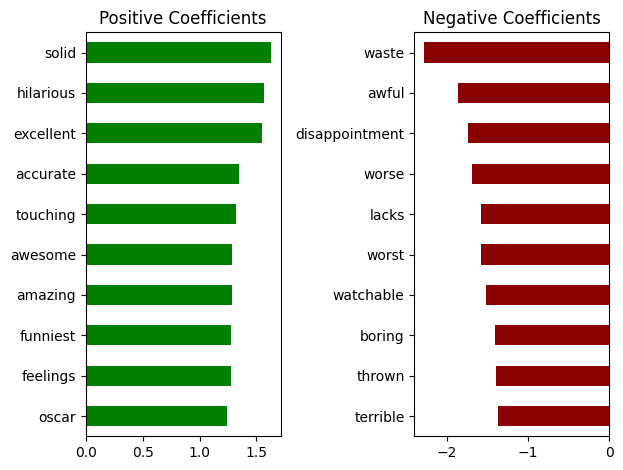

In [22]:
# Pull out the coefficients and feature names
coef_series = pd.Series(logit.coef_[0], index=cv.get_feature_names_out())

# Plot
import matplotlib.pyplot as plt

plt.subplots(1,2)

# Positive
plt.subplot(1,2,1)
coef_series.nlargest(10).sort_values().plot(kind='barh', color='green')
plt.title('Positive Coefficients')

# Negative
plt.subplot(1,2,2)
coef_series.nsmallest(10).sort_values(ascending=False).plot(kind='barh', color='darkred')
plt.title('Negative Coefficients')

# Show
plt.tight_layout()
plt.show()

We can see that the words appearing in reviews with positive reviews are highly positive, and those in negative reviews are very negative as we would expect. Some tokens might warrant more further investigation into the data if they are nouns.

### Using an LLM for Sentiment

In the section below, we will use the [transformers](https://huggingface.co/docs/transformers/index) library from Hugging Face to use a large language model, in this case, an example of one based on the very well-known [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)) model, for sentiment analysis.

If you've not already installed the `transformers` library, you'll need to do so below. The calls to the library will also download the model file. Note that these are large downloads, so may take a little while if you are running you code locally!

In [23]:
# Install the transformers library
!pip install transformers

In [24]:
# Create a model pipeline
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

# Create a sentiment analysis pipeline
mypipeline = pipeline("sentiment-analysis",
                      model="assemblyai/distilbert-base-uncased-sst2",
                      tokenizer="assemblyai/distilbert-base-uncased-sst2")

mypipeline(["I love applesauce!", "I hate applesauce!", "Applesauce is alright I guess"])

C:\Users\myles\venv\nlpforme\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[{'label': 'LABEL_1', 'score': 0.9970933198928833},
 {'label': 'LABEL_0', 'score': 0.9670106172561646},
 {'label': 'LABEL_1', 'score': 0.7049165368080139}]

Here, `LABEL_1` refers to positive sentiment, and `LABEL_0` to negative sentiment. We will delve more into Transformers and Large Language Models (LLMs) later in the course.

### References

• Maas, A., Daly, R., Pham, P., Huang, D., Ng, A., & Potts, C. (2011). Learning Word Vectors for Sentiment Analysis. In *Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies* (pp. 142–150). Association for Computational Linguistics.

• Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. In *Eighth International Conference on Weblogs and Social Media (ICWSM-14)*. Ann Arbor, MI, June 2014.

• *IMDB Dataset of 50K Movie Reviews.* (2019, March 9). Kaggle. https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

• *Distilbert-base-uncased-sst2 by AssemblyAI.* Hugging Face (Accessed July 21, 2023) https://huggingface.co/assemblyai/distilbert-base-uncased-sst2

<div align="right" float="right"><a href="https://www.github.com/nlpfromscratch/nlpfor.me" style="float: right; text-align: right; text-decoration: none; color: black">NLPfor.me 🔠⚡🤖🧠😃</a>